In the project, I am going to try to use all the features in our dataset to improve our model. This means that i have to do a more careful cleaning of the dataset and consider some of the finer points of linear models.

## Prepare Data

### Import

In [2]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np

from glob import glob
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline

warnings.filterwarnings("ignore")

In [3]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    mask_place = df["place_with_parent_names"].str.contains("Capital Federal")
    
    mask_apt = df["property_type"] == "apartment"
    
    mask_price = df["price_aprox_usd"] < 400_000
    
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    
    df = df[mask_place & mask_apt & mask_price & mask_area]
    
    df.drop(columns=["lat-lon"], inplace=True)
    
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    
    df.drop(columns=["place_with_parent_names"],inplace=True)
    
    df.drop(columns=["created_on", "place_name", "geonames_id", "description", "title", "image_thumbnail"], inplace=True)
    
    df.drop(columns=["floor", "expenses"], inplace=True)
    
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    df.drop(columns=["price_aprox_local_currency", "price", "price_per_m2", "price_usd_per_m2"], inplace=True)
    
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    
    return df

Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. Assign this list to the variable name files.

In [4]:
files = glob('properati-AR-2016-11-01-properties-*.csv')
files

['properati-AR-2016-11-01-properties-1.csv',
 'properati-AR-2016-11-01-properties-2.csv']

In [ ]:
frame = [wrangle(file) for file in files]
# frames = []
# for file in files:
#     df = wrangle(file)
#     frames.append(df)
frame

Use pd.concat to concatenate it items in frames into a single DataFrame df. Making sure that it set the ignore_index argument to True.

In [24]:
df = pd.concat(frame, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16145 entries, 0 to 16144
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    15490 non-null  float64
 1   lon                    15490 non-null  float64
 2   price_aprox_usd        16145 non-null  float64
 3   surface_covered_in_m2  16145 non-null  float64
 4   neighborhood           16145 non-null  object 
dtypes: float64(4), object(1)
memory usage: 630.8+ KB
None


,lat,lon,price_aprox_usd,surface_covered_in_m2,neighborhood
0,-34.603185,-58.363520,920.77,70.0,Puerto Madero
1,-34.612117,-58.362471,7000.00,220.0,Puerto Madero
2,-34.622564,-58.434761,243.34,57.0,Caballito
3,-34.608636,-58.403405,138.11,45.0,Balvanera
4,-34.580804,-58.412091,1249.62,130.0,Palermo


In [75]:
#df.drop(columns=["created_on", "place_name", "geonames_id", "description", "title", "image_thumbnail"], inplace=True)

### Explore

The first thing i need to consider when trying to use all the features df is missing values. While it's true i can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

Take a look at the output from df.info() above. Are there columns where more than half of the values are NaN? If so, those columns need to go!

Modify your wrangle function to drop 
NaN values, 

leaky, 

multicolinearity and 

high- and low-cardinality categorical features.

Be sure to rerun all the cells above before you continue.

In [76]:
df.isnull().sum() / len(df)

lat                      0.04057
lon                      0.04057
price_aprox_usd          0.00000
surface_covered_in_m2    0.00000
neighborhood             0.00000
dtype: float64

In [77]:
df.select_dtypes(object).head()

,neighborhood
0,Villa Crespo
1,Villa Devoto
2,Chacarita
3,Palermo
4,Barracas


In [78]:
df.select_dtypes(float).nunique()

lat                      9925
lon                      9960
price_aprox_usd          2491
surface_covered_in_m2     234
dtype: int64

In [79]:
corr = df.select_dtypes(float).drop(columns="price_aprox_usd").corr()
corr

,lat,lon,surface_covered_in_m2
lat,1.000000,0.940895,-0.004053
lon,0.940895,1.000000,0.002381
surface_covered_in_m2,-0.004053,0.002381,1.000000


<Axes: >

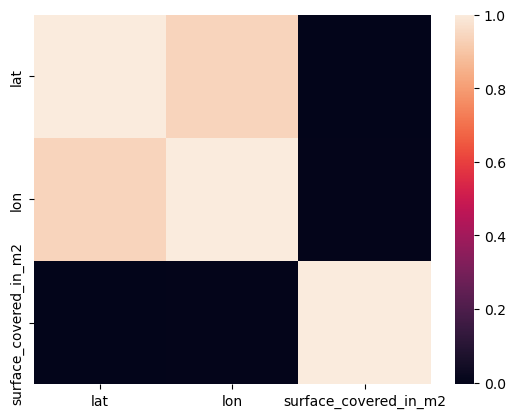

In [80]:
sns.heatmap(corr)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16145 entries, 0 to 16144
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    15490 non-null  float64
 1   lon                    15490 non-null  float64
 2   price_aprox_usd        16145 non-null  float64
 3   surface_covered_in_m2  16145 non-null  float64
 4   neighborhood           16145 non-null  object 
dtypes: float64(4), object(1)
memory usage: 630.8+ KB


### Split Data

Creating feature matrix X_train and target vector y_train. The target is "price_aprox_usd". The features should be all the columns that remain in the DataFrame you cleaned above.

In [87]:
target = "price_aprox_usd"

y=df[target]
X = df.drop(columns=target)

In [85]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16145 entries, 0 to 16144
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    15490 non-null  float64
 1   lon                    15490 non-null  float64
 2   surface_covered_in_m2  16145 non-null  float64
 3   neighborhood           16145 non-null  object 
dtypes: float64(3), object(1)
memory usage: 504.7+ KB


### Baseline

In [89]:
y_mean=y.mean()
y_pred_baseline = [y_mean]*len(y)
mae_baseline = mean_absolute_error(y, y_pred_baseline)
print("mean price:", y_mean.round(2))
print("baseline MAE:", mae_baseline.round(2))

mean price: 134984.9
baseline MAE: 66154.97


### Iterate

Creating a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.

In [97]:
ohe = OneHotEncoder().fit(X)

xt = ohe.transform(X)

imputer = SimpleImputer().fit(xt)

xt_train = imputer.transform(xt)

In [100]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
).fit(X,y)

In [101]:
model

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [102]:
y_pred_train = model.predict(X)
mae_basline = mean_absolute_error(y, y_pred_train)
print("trained mae:", mae_baseline.round(2))

trained mae: 66154.97


### Communicate Results

For this project, i relied on equations and visualizations for communication about the model. In many data science projects, however, communication means giving stakeholders tools they can use to deploy a model — in other words, use it in action. So let's look at two ways you might deploy this model.

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output.

In [105]:
intercept = model.named_steps["ridge"].intercept_
coefficient = model.named_steps["ridge"].coef_
print("intercept:", intercept.round(2))
print("coefficient:", coefficient.round(2)[:5])

intercept: 15065.22
coefficient: [ 1893.61 -1818.4    956.51 16316.06  9685.38]


In [107]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
feature_names

array(['lat', 'lon', 'surface_covered_in_m2', 'neighborhood_Villa Crespo',
       'neighborhood_Villa Devoto', 'neighborhood_Chacarita',
       'neighborhood_Palermo', 'neighborhood_Barracas',
       'neighborhood_Congreso', 'neighborhood_Nuñez',
       'neighborhood_Villa Urquiza', 'neighborhood_Almagro',
       'neighborhood_Villa Ortuzar', 'neighborhood_Balvanera',
       'neighborhood_Retiro', 'neighborhood_San Cristobal',
       'neighborhood_Liniers', 'neighborhood_Floresta',
       'neighborhood_Parque Centenario', 'neighborhood_',
       'neighborhood_Coghlan', 'neighborhood_Puerto Madero',
       'neighborhood_San Telmo', 'neighborhood_Parque Chacabuco',
       'neighborhood_Belgrano', 'neighborhood_Saavedra',
       'neighborhood_Barrio Norte', 'neighborhood_Recoleta',
       'neighborhood_Villa Luro', 'neighborhood_Monserrat',
       'neighborhood_Once', 'neighborhood_Parque Patricios',
       'neighborhood_Caballito', 'neighborhood_Tribunales',
       'neighborhood_Constitu

In [111]:
feat_imp = pd.Series(coefficient, feature_names)

neighborhood_Parque Patricios         135.476022
neighborhood_Villa General Mitre      511.740149
neighborhood_Paternal                -921.587821
surface_covered_in_m2                 956.510412
neighborhood_Villa del Parque        1065.621577
                                        ...     
neighborhood_Las Cañitas            45071.632178
neighborhood_Pompeya               -45480.640167
neighborhood_Villa Soldati         -47245.363886
neighborhood_Villa Riachuelo       -51615.010438
neighborhood_Puerto Madero         -65678.300132
Length: 61, dtype: float64

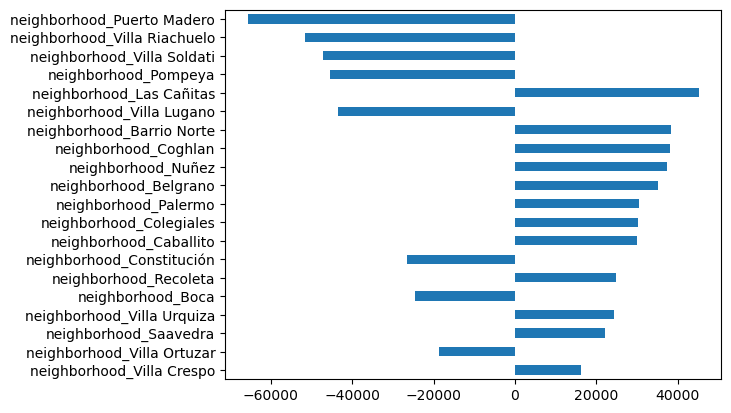

In [115]:
feat_imp.sort_values(key=abs).tail(20).plot(kind="barh");

In [ ]:
import spacy

